In [1]:
# 1. EDA 수행

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# 시각화 스타일 설정
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 데이터 로드
train_df = pd.read_csv("/kaggle/input/forest-cover-type-prediction/train.csv")


### 데이터 요약하기
print("[데이터 크기]", train_df.shape)
print("[메모리 사용량]", train_df.memory_usage(deep=True).sum() / (1024**2), "MB")


[데이터 크기] (15120, 56)
[메모리 사용량] 6.460086822509766 MB


### 1. EDA 수행

먼저 필요한 라이브러리를 불러오고, 시각화 환경을 설정했다.  
데이터셋은 Kaggle에서 제공한 train.csv 파일을 기준으로 분석을 시작했다.

- `sns.set(style="whitegrid")`: 시각화 결과를 보기 좋게 흰 배경 스타일로 설정
- `plt.rcParams["figure.figsize"]`: 전체 플롯 크기를 넉넉하게 설정하여 가독성 확보

### 데이터 요약

- 데이터의 크기 (`행, 열`)와 전체 메모리 사용량을 출력하여 데이터의 대략적인 규모를 파악했다.
  - `train_df.shape`: 데이터에 총 15120개의 레코드와 55개의 열이 있다는 것을 확인
  - `train_df.memory_usage`: 메모리 사용량은 약 6.35MB로, 처리에 큰 부담이 없는 수준


In [2]:
### 피처 및 타겟값 이해
info_df = pd.DataFrame({
    "Data Type": train_df.dtypes,
    "Missing Values": train_df.isnull().sum(),
    "Unique Values": train_df.nunique(),
    "Sample Value": train_df.iloc[0]
})
print(info_df)



                                   Data Type  Missing Values  Unique Values  \
Id                                     int64               0          15120   
Elevation                              int64               0           1665   
Aspect                                 int64               0            361   
Slope                                  int64               0             52   
Horizontal_Distance_To_Hydrology       int64               0            400   
Vertical_Distance_To_Hydrology         int64               0            423   
Horizontal_Distance_To_Roadways        int64               0           3250   
Hillshade_9am                          int64               0            176   
Hillshade_Noon                         int64               0            141   
Hillshade_3pm                          int64               0            247   
Horizontal_Distance_To_Fire_Points     int64               0           2710   
Wilderness_Area1                       int64        

### 피처 및 타겟값 이해

전체 피처와 타겟값에 대한 구조적 이해를 위해 아래 정보를 요약했다:

- 각 컬럼의 데이터 타입 (`Data Type`)
- 결측치 존재 여부 (`Missing Values`)
- 고유값 개수 (`Unique Values`)
- 첫 번째 샘플 값 (`Sample Value`)

이를 통해 어떤 피처가 범주형인지, 수치형인지, 결측이 있는지 등을 한 번에 파악할 수 있다.  
이는 이후 인코딩 전략 결정이나 파생 피처 설계 시 기준 자료로 활용 가능하다.


In [3]:
# 수치형, 범주형 피처 구분
numeric_features = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
    'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]
categorical_features = [col for col in train_df.columns if 'Wilderness_Area' in col or 'Soil_Type' in col]

### 불필요한 피처 제거
if 'Id' in train_df.columns:
    train_df.drop(columns=['Id'], inplace=True)



### 수치형 및 범주형 피처 구분 + 불필요한 피처 제거

데이터 전처리를 효율적으로 하기 위해 피처들을 **수치형과 범주형으로 구분**했다.

- `numeric_features`: 연속적인 수치값을 가지는 변수들로 모델 학습 시 스케일링 대상이 됨
- `categorical_features`: `Wilderness_Area` 및 `Soil_Type` 관련 One-Hot 인코딩된 범주형 변수들

또한 불필요한 피처인 `'Id'`는 예측과 무관하므로 제거하였다.  
이는 후속 작업에서 모델에 불필요한 정보가 들어가는 것을 방지하기 위함이다.


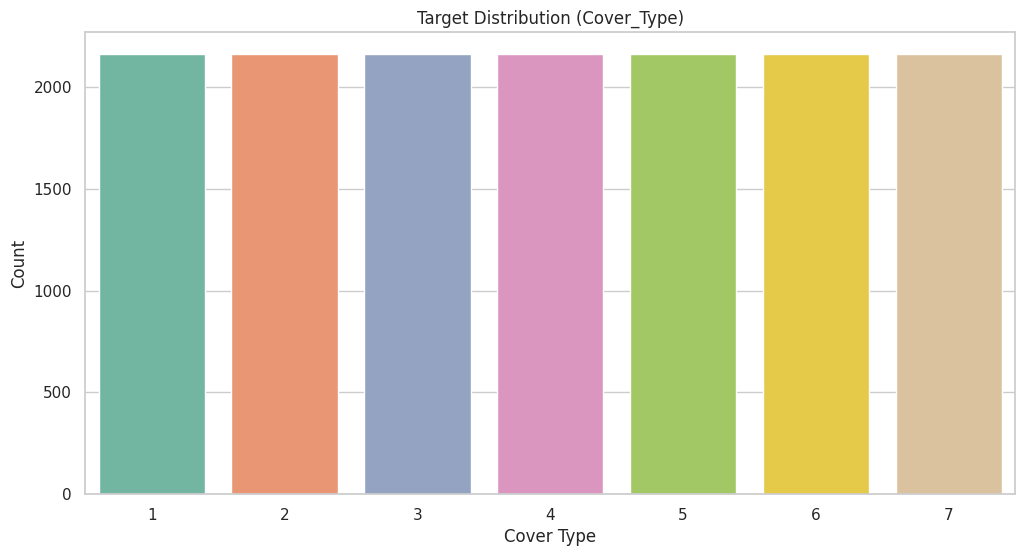

In [4]:
### 타겟값 분포 시각화
sns.countplot(x='Cover_Type', data=train_df, palette="Set2")
plt.title('Target Distribution (Cover_Type)')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.show()


### 타겟값 분포 시각화

타겟 변수인 `Cover_Type`의 클래스 분포를 시각적으로 확인했다.  
분포가 불균형할 경우 모델의 성능에 영향을 줄 수 있으므로,  
클래스 간 균형 여부를 파악하는 데 중요하다.


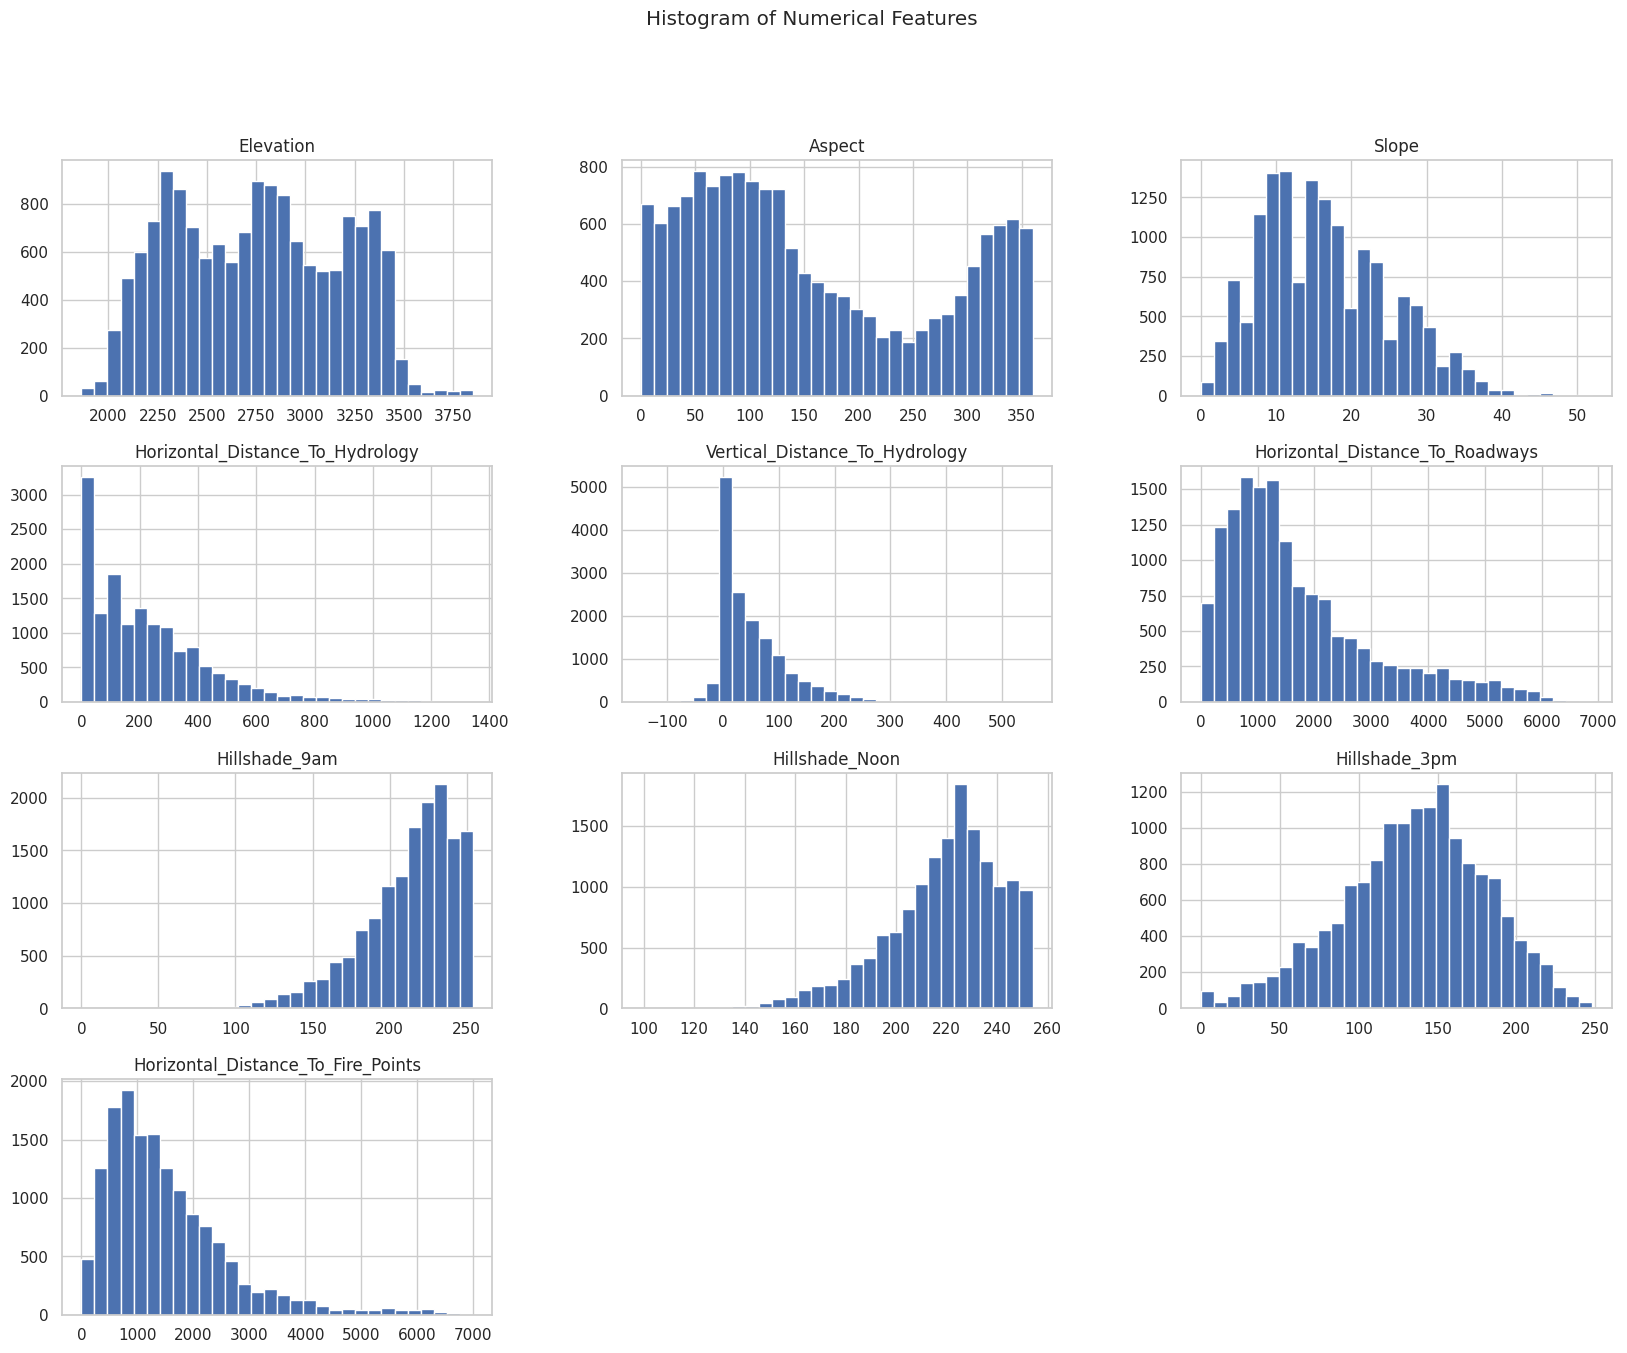

In [5]:
### 수치형 변수 분포 시각화
train_df[numeric_features].hist(bins=30, figsize=(20, 15), layout=(4, 3))
plt.suptitle('Histogram of Numerical Features')
plt.show()



### 수치형 변수 분포 시각화

각 수치형 피처의 전체 분포를 파악하기 위해 히스토그램을 그렸다.  
데이터가 치우쳐 있는지, 이상치가 눈에 띄게 존재하는지 등을 확인할 수 있으며,  
스케일링 필요 여부나 정규화 전략 수립에 참고가 된다.


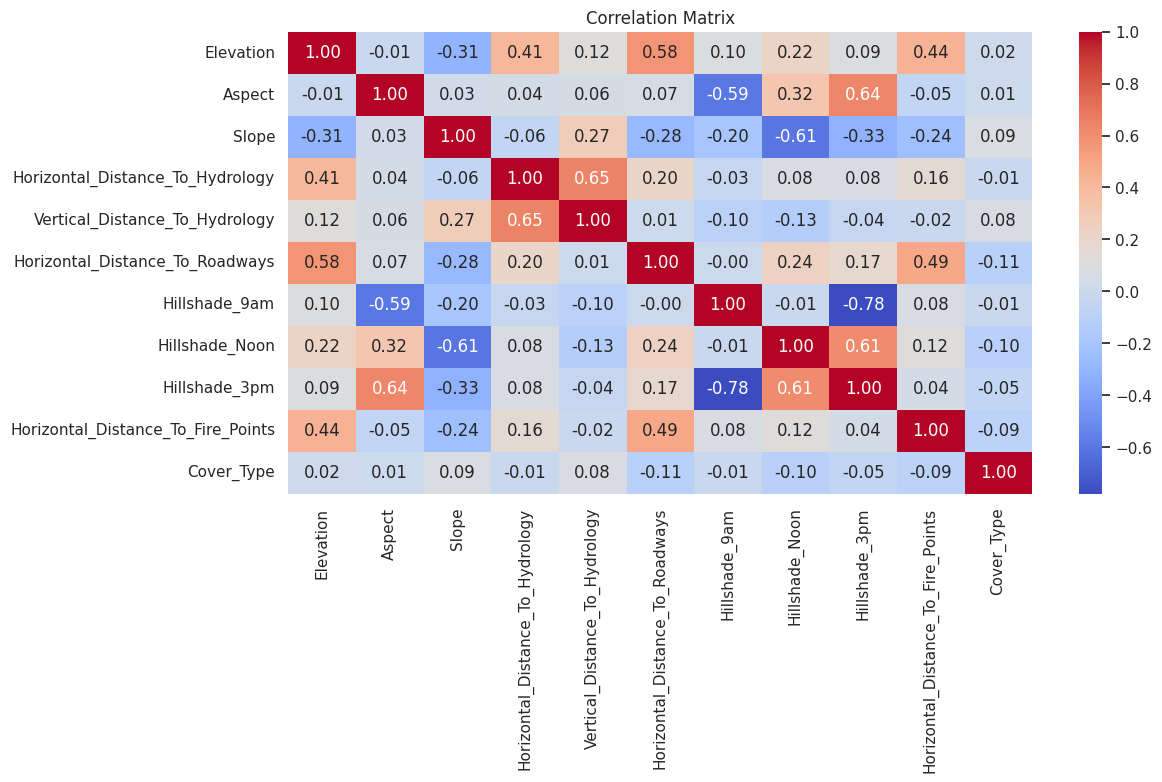

In [6]:
### 상관관계 히트맵
correlation_matrix = train_df[numeric_features + ['Cover_Type']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



### 상관관계 히트맵

수치형 피처들과 타겟값(`Cover_Type`) 간의 상관관계를 파악하기 위해 히트맵을 시각화했다.  
이를 통해 타겟과 강한 상관을 가지는 변수나, 서로 강하게 연관된 피처들을 확인할 수 있다.  
중복된 정보를 가진 피처를 제거하거나 조합 피처를 설계할 때 참고 자료로 활용된다.


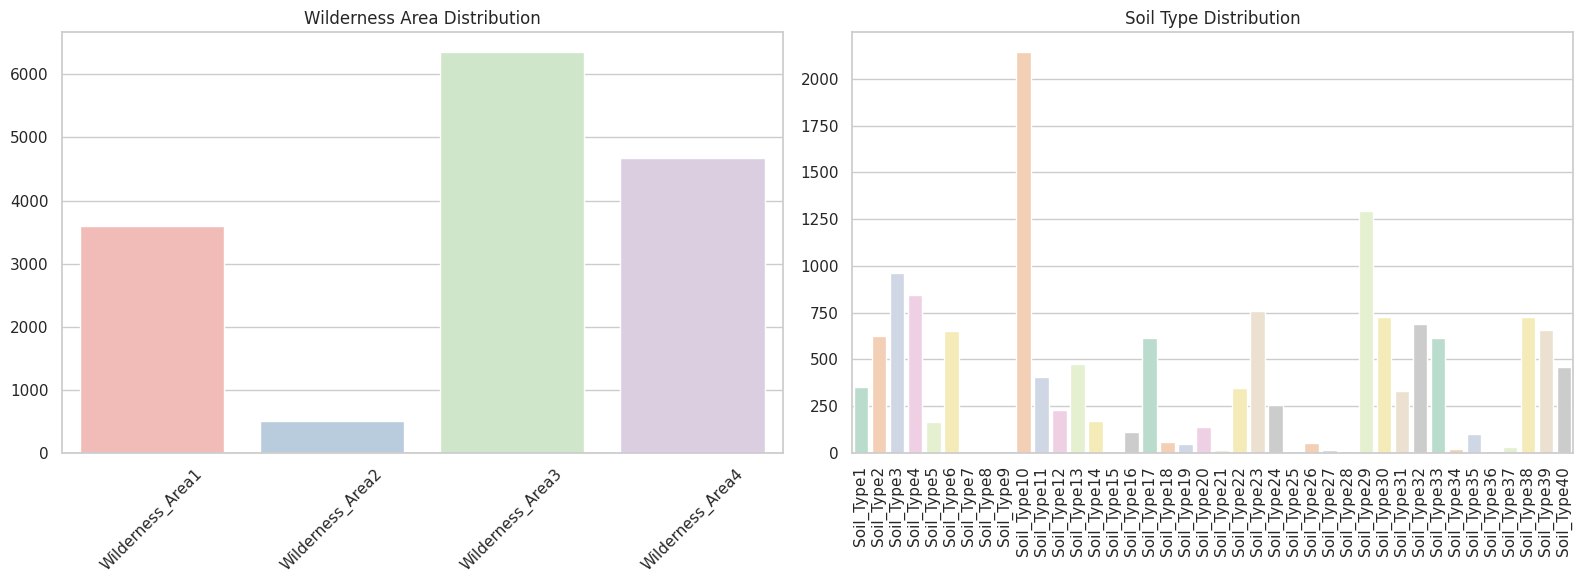

In [7]:
### 범주형 피처 분포 시각화
wilderness_counts = train_df[[col for col in categorical_features if 'Wilderness' in col]].sum()
soil_counts = train_df[[col for col in categorical_features if 'Soil_Type' in col]].sum()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=wilderness_counts.index, y=wilderness_counts.values, ax=ax[0], palette="Pastel1")
ax[0].set_title('Wilderness Area Distribution')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(x=soil_counts.index, y=soil_counts.values, ax=ax[1], palette="Pastel2")
ax[1].set_title('Soil Type Distribution')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


### 범주형 피처 분포 시각화

One-Hot 인코딩된 `Wilderness_Area`와 `Soil_Type`의 각 클래스 분포를 시각화했다.  
각 범주의 샘플 수를 확인함으로써 데이터의 클래스 불균형 여부를 파악할 수 있으며,  
모델의 일반화 성능에 영향을 줄 수 있는 편향 여부를 확인하는 데 활용된다.


In [8]:
### 이상치 탐지 및 처리 방법
z_scores = np.abs(zscore(train_df[numeric_features]))
outliers = (z_scores > 3).sum(axis=0)
print("[Z-score > 3 이상치 개수]")
print(pd.Series(outliers, index=numeric_features).sort_values(ascending=False))

### 추가 피처 통합 (선택적으로 모델 튜닝 시 활용 가능)
# One-hot 인코딩된 wilderness/soil 정보를 단일 컬럼으로 통합하여 시도 가능
train_df['Wilderness_Area'] = train_df[[col for col in train_df.columns if 'Wilderness_Area' in col]].idxmax(axis=1)
train_df['Soil_Type'] = train_df[[col for col in train_df.columns if 'Soil_Type' in col]].idxmax(axis=1)


[Z-score > 3 이상치 개수]
Horizontal_Distance_To_Fire_Points    331
Horizontal_Distance_To_Hydrology      285
Vertical_Distance_To_Hydrology        213
Hillshade_9am                         160
Horizontal_Distance_To_Roadways       155
Hillshade_Noon                        129
Slope                                  39
Elevation                               0
Aspect                                  0
Hillshade_3pm                           0
dtype: int64


### 이상치 탐지 및 처리 방법

Z-score 기준으로 수치형 피처들에 대해 이상치를 탐지했다.  
Z-score가 3을 초과하는 값을 이상치로 간주하고, 피처별로 이상치 개수를 집계하여  
어떤 변수에 이상치가 집중되어 있는지 확인할 수 있다.

### 추가 피처 통합

One-Hot 인코딩된 `Wilderness_Area`와 `Soil_Type` 정보를 단일 컬럼으로 통합했다.  
이는 모델 튜닝 시 피처 수를 줄이거나 범주형 처리를 간소화하기 위한 전략으로 활용 가능하다.  
단, 통합된 값은 문자열이기 때문에 인코딩 과정에서 주의가 필요하다.


In [9]:
# 2. Feature Engineering

from sklearn.preprocessing import StandardScaler

### 이상치 제거
# Z-score가 4 이상인 행을 제거하여 극단치 완화
z_threshold = 4
z_scores = np.abs(zscore(train_df[numeric_features]))
train_df = train_df[(z_scores < z_threshold).all(axis=1)]

### 범주형 컬럼 다시 인코딩 - 통합된 피처 기준
# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['Wilderness_Area'] = le.fit_transform(train_df['Wilderness_Area'])
train_df['Soil_Type'] = le.fit_transform(train_df['Soil_Type'])

### 파생 피처 생성
# 수변 거리 총합, 거리 차이 절대값 등 조합 피처 생성
train_df['Total_Hydrology_Distance'] = train_df['Horizontal_Distance_To_Hydrology'] + abs(train_df['Vertical_Distance_To_Hydrology'])
train_df['Elevation_plus_VerticalHydro'] = train_df['Elevation'] + train_df['Vertical_Distance_To_Hydrology']
train_df['Hillshade_Mean'] = train_df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)

#6월 8일. 점수가 너무 낮은 거 같아 몇몇 파생 피처를 추가로 생성하기로 하였음.
# 거리 차이 절대값
train_df['Hydro_Road_Diff'] = abs(train_df['Horizontal_Distance_To_Hydrology'] - train_df['Horizontal_Distance_To_Roadways'])

# 경사와 고도 상호작용
train_df['Slope_Elevation_Interaction'] = train_df['Slope'] * train_df['Elevation']

# 불과 수계 사이의 거리 관계를 비율,  도로 근접성과 태양광량의 상호작용
train_df['Hydro_Fire_Ratio'] = train_df['Horizontal_Distance_To_Hydrology'] / (train_df['Horizontal_Distance_To_Fire_Points'] + 1)
train_df['Road_Hillshade'] = train_df['Horizontal_Distance_To_Roadways'] * train_df['Hillshade_Noon']

### 수치형 피처 표준화
scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])

print("체크")

체크


### 2. Feature Engineering

이 단계에서는 모델의 성능을 높이기 위한 다양한 전처리 및 피처 엔지니어링을 수행했다.

- **이상치 제거**  
  수치형 변수에서 Z-score가 4 이상인 값을 갖는 행은 극단값으로 판단하여 제거하였다.  
  이는 모델 학습 시 과도한 영향을 주는 이상치를 제거함으로써 예측 성능 저하를 방지하기 위함

- **범주형 변수 인코딩**  
  통합된 `Wilderness_Area`와 `Soil_Type` 컬럼은 문자열이므로, `LabelEncoder`를 이용해 정수로 변환

- **파생 피처 생성 및 확장**  
  원본 피처 간의 관계를 반영한 **새로운 조합 피처**를 생성하여 지형 및 환경 정보를 더 정밀하게 반영하였다. 주요 파생 피처는 모델을 돌려가며 성능을 개선하기 위해 추가해 나아갔고 다음과 같은 것들이 있다.
  
  - `Total_Hydrology_Distance`: 수평 및 수직 수변 거리의 총합  
  - `Elevation_plus_VerticalHydro`: 고도와 수직 수변 거리의 합  
  - `Hillshade_Mean`: 오전/정오/오후 일사량의 평균  
  - `Hydro_Road_Diff`: 수변 거리와 도로 거리의 차이  
  - `Slope_Elevation_Interaction`: 경사와 고도의 곱 (지형의 가파름 정도 반영)  
  - `Hydro_Fire_Ratio`: 수변 거리와 화재지점 거리의 비율  
  - `Road_Hillshade`: 도로 거리와 정오 일사량의 곱

  이러한 파생 피처들은 단일 거리나 고도 값보다 더 복합적인 지형 특성을 담고 있기에 
  모델이 보다 정교한 패턴을 학습할 수 있도록 돕는다.

- **수치형 피처 정규화**  
  수치형 피처는 `StandardScaler`를 이용해 정규화하여 평균 0, 표준편차 1로 조정했다.  
  이는 추후 트리 기반이 아닌 다른 모델로 확장할 때도 안정적인 학습이 가능하도록 하기 위한 조치이다.


In [10]:
# 3. Model Development:

### 평가지표 계산 함수 정의
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

### 훈련/검증 데이터 분리
from sklearn.model_selection import train_test_split
X = train_df.drop("Cover_Type", axis=1)
y = train_df["Cover_Type"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("체크")

### 모델 및 하이퍼파라미터 탐색
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# model = RandomForestClassifier(random_state=42, n_jobs=-1)
#성능 향상을 위해 모델 교채.
# from sklearn.ensemble import ExtraTreesClassifier 
# model = ExtraTreesClassifier(
#     n_estimators=500, #안정성 향상을 위해 더 많은 트리 설정
#     max_depth=40, #깊이 크게 설정 
#     min_samples_split=2,
#     min_samples_leaf=1,
#     random_state=42,
#     n_jobs=-1
# )
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# 모델들을 앙상블을 사용한 모델로 교체함
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

et_model = ExtraTreesClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_model = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42, n_jobs=-1)
lgbm_model = LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=64, max_depth=15, random_state=42)

voting_model = VotingClassifier(
    estimators=[('et', et_model), ('rf', rf_model), ('lgbm', lgbm_model)],
    voting='soft',  # 확률 평균
    n_jobs=-1
)
voting_model.fit(X_train, y_train)

#StratifiedKFold로 교차 검증 추가 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(voting_model, X, y, cv=cv, scoring='accuracy')
print("Average CV Accuracy:", scores.mean())
### 최적 모델 평가
# best_model = grid_search.best_estimator_
y_pred = voting_model.predict(X_valid)
# y_pred = best_model.predict(X_valid)
# evaluate_model(y_valid, y_pred)



체크
Average CV Accuracy: 0.8790541085680402


### Model Development

~~랜덤 포레스트를 기반으로 모델을 개발하고, GridSearchCV를 활용해 하이퍼파라미터 최적화를 수행했다~~ 6월 8일 수정

### 6월 8일 수정:
- 단일 트리 기반 모델(RandomForest, ExtraTrees 등)보다 높은 성능을 위해  
**ExtraTreesClassifier, RandomForestClassifier, LGBMClassifier**를 결합한 **VotingClassifier 앙상블 모델**을 도입하였다.  
또한, 교차검증을 통한 평균 정확도를 함께 계산하여 일반화 성능을 점검하였다.

- **평가지표 함수 정의**:  
  모델 성능을 `accuracy`, `weighted f1 score`, `classification report` 기준으로 종합 평가할 수 있도록 함수로 정의했다.

- **데이터 분할**:  
  전체 데이터를 훈련/검증 세트로 8:2 비율로 나누고, 클래스 불균형을 고려해 `stratify` 옵션을 사용했다.

- **앙상블 모델 구축**:  
  서로 다른 세 가지 트리 기반 모델(ExtraTrees, RandomForest, LGBM)을 조합하여 Voting 방식으로 예측을 수행하도록 하였다.  
  각 모델의 예측 확률을 평균내는 `soft voting` 방식을 사용해, 다양한 모델의 강점을 조합하였다.

- **교차 검증 평가**:  
  StratifiedKFold 기반의 5-fold 교차검증을 수행해 평균 정확도를 산출하고, 모델의 안정성을 확인하였다.

- **최종 모델 평가**:  
  검증 데이터셋에 대해 앙상블 모델의 성능을 평가하였고, 추후 테스트셋 예측에 활용될 예정이다.

In [11]:
# 4. Model Evaluation and Reporting

### 테스트 데이터 불러오기
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

test_df = pd.read_csv("/kaggle/input/forest-cover-type-prediction/test.csv")

# 동일한 전처리 적용
test_df['Wilderness_Area'] = test_df[[col for col in test_df.columns if 'Wilderness_Area' in col]].idxmax(axis=1)
test_df['Soil_Type'] = test_df[[col for col in test_df.columns if 'Soil_Type' in col]].idxmax(axis=1)

le = LabelEncoder()
test_df['Wilderness_Area'] = le.fit_transform(test_df['Wilderness_Area'])
test_df['Soil_Type'] = le.fit_transform(test_df['Soil_Type'])

# 파생 피처 생성
test_df['Total_Hydrology_Distance'] = test_df['Horizontal_Distance_To_Hydrology'] + abs(test_df['Vertical_Distance_To_Hydrology'])
test_df['Elevation_plus_VerticalHydro'] = test_df['Elevation'] + test_df['Vertical_Distance_To_Hydrology']
test_df['Hillshade_Mean'] = test_df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)

# 추가한 파생 피처 코드에 대한 테스트 추가 - 테스트 데이터
test_df['Hydro_Road_Diff'] = abs(test_df['Horizontal_Distance_To_Hydrology'] - test_df['Horizontal_Distance_To_Roadways'])
test_df['Slope_Elevation_Interaction'] = test_df['Slope'] * test_df['Elevation']
# 추가한 데이터들 더 추가
test_df['Hydro_Fire_Ratio'] = test_df['Horizontal_Distance_To_Hydrology'] / (test_df['Horizontal_Distance_To_Fire_Points'] + 1)
test_df['Road_Hillshade'] = test_df['Horizontal_Distance_To_Roadways'] * test_df['Hillshade_Noon']

# 수치형 피처 표준화
numeric_features = [
    'Elevation', 'Aspect', 'Slope',
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]
# scaler = StandardScaler()
# test_df[numeric_features] = scaler.fit_transform(test_df[numeric_features])

# train_df에서 이미 fit한 scaler 사용으로 변경
test_df[numeric_features] = scaler.transform(test_df[numeric_features])


# 예측에 필요한 컬럼만 사용
X_test = test_df[X.columns]
# test_preds = best_model.predict(X_test)
test_preds = voting_model.predict(X_test)

# 제출 파일 생성
submission = pd.read_csv("/kaggle/input/forest-cover-type-prediction/sampleSubmission.csv")
submission['Cover_Type'] = test_preds
submission.to_csv("submission.csv", index=False)
#확인용
print("submission.csv 파일이 생성 완료")


submission.csv 파일이 생성 완료


### Model Evaluation and Reporting

6월 8일 수정:  
**ExtraTreesClassifier, RandomForestClassifier, LGBMClassifier** 세 가지 모델을 결합한 **VotingClassifier(soft voting)** 기반의 앙상블 모델을 도입하였다.  
이를 통해 각 모델의 예측 결과를 확률 기반으로 평균 내어 보다 안정적이고 높은 정확도를 기대할 수 있도록 하였다.

- **평가지표 함수 정의**:  
  모델 성능을 `accuracy`, `weighted f1 score`, `classification report` 기준으로 종합 평가할 수 있도록 함수로 정의했다.

- **데이터 분할**:  
  전체 데이터를 훈련/검증 세트로 8:2 비율로 나누고, 클래스 불균형을 고려해 `stratify` 옵션을 사용했다.


- **앙상블 모델 구성**:  
  서로 다른 트리 기반 분류기들을 soft voting 방식으로 결합한 모델을 구축하였으며, 개별 모델의 장점을 조합하여 전반적인 예측 성능을 향상시켰다.

- **추가 검증 - Stratified K-Fold**:  
  보다 신뢰도 높은 모델 성능 평가를 위해 `StratifiedKFold(n_splits=5)` 기반의 `cross_val_score`를 수행하였다.  
  이로써 각 fold에 따른 정확도 평균을 산출하고 모델의 일반화 성능을 검토하였다.

- **최종 모델 예측 및 제출 생성**:  
  앙상블 모델을 기반으로 테스트 데이터에 대한 예측을 수행하였고, Kaggle 제출 형식에 맞춰 `submission.csv`를 생성하였다.
